# Using Pyspark to Make rdf model and comparing to MLR model

In [1]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.regression import LabeledPoint

In [2]:
sc

## Use 1996-2005 data to predict current values

In [43]:
#this allows me to directly connect to hadoop
path = 'hdfs:///user/msteinme99/project2nolabel.csv'
predictive_old_urea = sc.textFile(path)
predictive_old_urea.count()

3653

In [44]:
columnNames_old = ('latedate', 'Spotdollar', '2monthcrude', '2monthcorn','precipitation', 'temp', '2monthurea','earlydate','dollar', 'crude','corn','urea', 'lastdate', 'crude.1', 'urea.1')
#this shows the first column which is to see if file connection worked
predictive_old_urea.first()

u'3/1/12,78.789,109.27,654,406,5.18,76.2,1/1/96,84.76,19.06,371.5,235,2/1/14,96.71,450'

In [45]:
#interested in dollar, crude, corn and urea columns
predictiveUreaSelected_old = predictive_old_urea.map(lambda row:row.split(',')).map(lambda row: (float(row[8]), float(row[9]), float(row[10]), float(row[11])))
predictiveUreaSelected_old.first()

(84.76, 19.06, 371.5, 235.0)

In [46]:
#taking urea as the y, and grouping dollar,crude,corn as the x variables
predictiveUreaLabeled_old = predictiveUreaSelected_old.map(lambda row:LabeledPoint(row[3],[row[0],row[1],row[2]]))
predictiveUreaLabeled_old.first()

LabeledPoint(235.0, [84.76,19.06,371.5])

In [47]:
#spliting data into training and test datasets, training should be from .6-.8
(trainingData, testData) = predictiveUreaLabeled_old.randomSplit([0.7,0.3])
trainingData.count()

2575

In [24]:
testData.count()

1115

In [25]:
# Train a RandomForest model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
#  Note: Use larger numTrees in practice.
#  Setting featureSubsetStrategy="auto" lets the algorithm choose.
model_old = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    numTrees=200, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)

In [26]:
predictions = model_old.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression forest model:')

Test Mean Squared Error = 129.187265902
Learned regression forest model:


In [28]:
# Save and load model 
model_old.save(sc, "hdfs:///user/msteinme99/olderurea4")

In [71]:
rdfModel_old = RandomForestModel.load(sc,"hdfs:///user/msteinme99/olderurea4")

In [72]:
tobePredictedUrea = sc.textFile("hdfs:///user/msteinme99/predict2.csv")
tobePredictedUrea.take(8)

[u'98.148,34.58,359.5',
 u'98.211,35.58,357',
 u'98.352,36.15,355.75',
 u'98.214,36.3,356.25',
 u'97.592,36.33,356.5',
 u'97.34,37.75,358.25',
 u'97.071,39.82,359',
 u'97.255,38.77,359.5']

In [73]:
predictions_old = rdfModel_old.predict(tobePredictedUrea.map(lambda x: x.split(',')))
predictions_old.take(8)

[191.0267745457433,
 192.31666562946262,
 192.31666562946262,
 192.31666562946262,
 192.31666562946262,
 192.31666562946262,
 210.57599208991348,
 192.31666562946262]

In [80]:
#mlr_96_05 = 137.0734 - (1.1225 * dollar) + (3.4372 * crude) + (0.2556 * corn)
#mlr_china = 889.9160 - (5.8976 * dollar) + (2.9201 * crude) - (0.5137 * corn)
#mlr_section1 = 501.8951 - (3.5447 * dollar) + (0.2747 * corn)
#mlr_green = 246.2886 + (2.0300 * crude)
#mlr_section1_temp = -264.2950 - (3.9598 * dollar) + (0.1286 * corn) + (12.1178 * temp)
actual1 = 232
actual2 = 230
actual3 = 213
actual4 = 210
actual5 = 213
actual6 = 213
actual7 = 213
actual8 = 213

In [52]:
pred1_96 = 137.0734 - (1.1225 * 98.148) + (3.4372 * 34.58) + (0.2556 * 359.5)
pred2_96 = 137.0734 - (1.1225 * 98.211) + (3.4372 * 35.58) + (0.2556 * 357)
pred3_96 = 137.0734 - (1.1225 * 98.352) + (3.4372 * 36.15) + (0.2556 * 355.75)
pred4_96 = 137.0734 - (1.1225 * 98.214) + (3.4372 * 36.3) + (0.2556 * 356.25)
pred5_96 = 137.0734 - (1.1225 * 97.592) + (3.4372 * 36.33) + (0.2556 * 356.5)
pred6_96 = 137.0734 - (1.1225 * 97.34) + (3.4372 * 37.75) + (0.2556 * 358.25)
pred7_96 = 137.0734 - (1.1225 * 97.071) + (3.4372 * 39.82) + (0.2556 * 359)
pred8_96 = 137.0734 - (1.1225 * 97.255) + (3.4372 * 38.77) + (0.2556 * 359.5)

In [53]:
print pred1_96 
print pred2_96 
print pred3_96 
print pred4_96 
print pred5_96 
print pred6_96
print pred7_96
print pred8_96

237.648846
240.3763285
241.85776
242.656045
243.521256
249.13225
256.7409065
253.0531065


In [74]:
#error on each for rdf_old model
error1 = abs(191.0267745457433 - actual1)/actual1 * 100
error2 = abs(192.31666562946262 - actual2)/actual2 * 100
error3 = abs(192.31666562946262 - actual3)/actual3 * 100
error4 = abs(192.31666562946262 - actual4)/actual4 * 100
error5 = abs(192.31666562946262 - actual5)/actual5 * 100
error6 = abs(192.31666562946262 - actual6)/actual6 * 100
error7 = abs(210.57599208991348 - actual7)/actual7 * 100
error8 = abs(192.316665629462 - actual8)/actual8 * 100
print error1
print error2
print error3
print error4
print error5
print error6
print error7
print error8

17.6608730406
16.384058422
9.71048561997
8.42063541454
9.71048561997
9.71048561997
1.13803188267
9.71048561997


In [55]:
#error on each for mlr_old model, the rdf model is better
error1_mlr = abs(pred1_96 - actual1)/actual1 * 100
error2_mlr = abs(pred2_96 - actual2)/actual2 * 100
error3_mlr = abs(pred3_96 - actual3)/actual3 * 100
error4_mlr = abs(pred4_96 - actual4)/actual4 * 100
error5_mlr = abs(pred5_96 - actual5)/actual5 * 100
error6_mlr = abs(pred6_96 - actual6)/actual6 * 100
error7_mlr = abs(pred7_96 - actual7)/actual7 * 100
error8_mlr = abs(pred8_96 - actual8)/actual8 * 100
print error1_mlr
print error2_mlr
print error3_mlr
print error4_mlr
print error5_mlr
print error6_mlr
print error7_mlr
print error8_mlr

2.43484741379
4.51144717391
13.5482441315
15.550497619
14.329228169
16.9634976526
20.5356368545
18.8042753521


## Use dates 8/3/15-2/25/15 and will eventually compare to mlr

In [7]:
path = 'hdfs:///user/msteinme99/ureachina.csv'      #file that has below columns and from 8/3/15 to 2/25/2016
predictchinaurea = sc.textFile(path)
predictchinaurea.count()

141

In [8]:
columnNames = ('latedate', 'Spotdollar', '2monthcrude', '2monthcorn','2monthurea', 'precipitation', 'temp')

In [9]:
predictchinaurea.first()

u'8/3/15,97.494,45.56,376.5,278,9.26,71.87'

In [10]:
#I didn't want to look at temp or precipitation yet so I did not use those columns
predictiveUreaSelected = predictchinaurea.map(lambda row:row.split(',')).map(lambda row: (float(row[1]), float(row[2]), float(row[3]), float(row[4])))
predictiveUreaSelected.first()

(97.494, 45.56, 376.5, 278.0)

In [11]:
#taking 2monthurea as the y, and grouping spotdollar,crude,corn as the x variables
predictiveUreaLabeled = predictiveUreaSelected.map(lambda row:LabeledPoint(row[3],[row[0],row[1],row[2]]))
predictiveUreaLabeled.first()

LabeledPoint(278.0, [97.494,45.56,376.5])

In [62]:
#spliting data into training and test datasets, training should be from .6-.8
(trainingData, testData) = predictiveUreaLabeled.randomSplit([0.7,0.3])
trainingData.count()

101

In [63]:
testData.count()

40

In [64]:
#using random forest in pyspark
model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    numTrees=200, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)

In [65]:
#this prints the MSE for the rdf model, want the mse to be small, made trees varying sizes and looked at changing MSE, do multiple times
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))
print('Learned regression forest model:')

Test Mean Squared Error = 75.5443238411
Learned regression forest model:


In [66]:
# Save and load model //user/msteinme99/project2nolabel.csv
model.save(sc, "hdfs:///user/msteinme99/chinaureamodel4")

In [69]:
#now need to load the file
rdfModel_China = RandomForestModel.load(sc,"hdfs:///user/msteinme99/chinaureamodel4")

In [76]:
tobePredictedUrea = sc.textFile("hdfs:///user/msteinme99/predict2.csv")
tobePredictedUrea.take(8)

[u'98.148,34.58,359.5',
 u'98.211,35.58,357',
 u'98.352,36.15,355.75',
 u'98.214,36.3,356.25',
 u'97.592,36.33,356.5',
 u'97.34,37.75,358.25',
 u'97.071,39.82,359',
 u'97.255,38.77,359.5']

In [70]:
rdfModel_China.predict?

In [77]:
predictions_China = rdfModel_China.predict(tobePredictedUrea.map(lambda x: x.split(',')))
predictions_China.take(8)

[216.47165476190474,
 218.77269047619043,
 221.5400892857143,
 221.4918988095238,
 226.47638690476194,
 228.0846369047619,
 251.23016666666663,
 240.22458333333338]

In [81]:
pred1_China = 889.9160 - (5.8976 * 98.148) + (2.9201 * 34.58) - (0.5137 * 359.5)
pred2_China = 889.9160 - (5.8976 * 98.211) + (2.9201 * 35.58) - (0.5137 * 357)
pred3_China = 889.9160 - (5.8976 * 98.352) + (2.9201 * 36.15) - (0.5137 * 355.75)
pred4_China = 889.9160 - (5.8976 * 98.214) + (2.9201 * 36.3) - (0.5137 * 356.25)
pred5_China = 889.9160 - (5.8976 * 97.592) + (2.9201 * 36.33) - (0.5137 * 356.5)
pred6_China = 889.9160 - (5.8976 * 97.34) + (2.9201 * 37.75) - (0.5137 * 358.25)
pred7_China = 889.9160 - (5.8976 * 97.071) + (2.9201 * 39.82) - (0.5137 * 359)
pred8_China = 889.9160 - (5.8976 * 97.255) + (2.9201 * 38.77) - (0.5137 * 359.5)
print pred1_China
print pred2_China
print pred3_China
print pred4_China
print pred5_China
print pred6_China
print pred7_China
print pred8_China

227.3802632
231.2130644
232.6880848
233.6831186
237.3106038
242.044366
249.2901524
244.882039


In [82]:
#error on each for rdf_old model china
error1_c = abs(216.47165476190474- actual1)/actual1 * 100
error2_c = abs(218.77269047619043- actual2)/actual2 * 100
error3_c = abs(221.5400892857143 - actual3)/actual3 * 100
error4_c = abs(221.4918988095238 - actual4)/actual4 * 100
error5_c = abs(226.47638690476194 - actual5)/actual5 * 100
error6_c = abs(228.0846369047619 - actual6)/actual6 * 100
error7_c = abs(251.23016666666663- actual7)/actual7 * 100
error8_c = abs(240.224583333333 - actual8)/actual8 * 100
print error1_c
print error2_c
print error3_c
print error4_c
print error5_c
print error6_c
print error7_c
print error8_c

6.6932522578
4.8814389234
4.00943158954
5.47233276644
6.32694220881
7.08198915717
17.9484350548
12.7814945227


In [83]:
#error on each for mlr_old model china
error1_mlrc = abs(pred1_China - actual1)/actual1 * 100
error2_mlrc = abs(pred2_China - actual2)/actual2 * 100
error3_mlrc = abs(pred3_China - actual3)/actual3 * 100
error4_mlrc = abs(pred4_China - actual4)/actual4 * 100
error5_mlrc = abs(pred5_China - actual5)/actual5 * 100
error6_mlrc = abs(pred6_China - actual6)/actual6 * 100
error7_mlrc = abs(pred7_China - actual7)/actual7 * 100
error8_mlrc = abs(pred8_China - actual8)/actual8 * 100
print error1_mlrc
print error2_mlrc
print error3_mlrc
print error4_mlrc
print error5_mlrc
print error6_mlrc
print error7_mlrc
print error8_mlrc

1.99126586207
0.527419304348
9.24323230047
11.2776755238
11.4134290141
13.6358525822
17.0376302347
14.9680934272


# Section 1 used to predict now & compare to mlr

In [130]:
#this allows me to directly connect to hadoop
path = 'hdfs:///user/msteinme99/sec1nolabel.csv'
predictive = sc.textFile(path)
predictive.count()

985

In [131]:
columnNames_sec1 = ('Spotdollar', '2monthcrude', '2monthcorn','2monthurea')
#this shows the first column which is to see if file connection worked
predictive.first()

u'78.789,109.27,654,406'

In [103]:
predictiveUreaSelected = predictive.map(lambda row:row.split(',')).map(lambda row: (float(row[0]), float(row[1]), float(row[2]), float(row[3])))
predictiveUreaSelected.first()

(78.789, 109.27, 654.0, 406.0)

In [104]:
#taking 2monthurea as the y, and grouping dollar,crude,corn as the x variables
predictiveUreaLabeled = predictiveUreaSelected.map(lambda row:LabeledPoint(row[3],[row[0],row[1],row[2]]))
predictiveUreaLabeled.first()

LabeledPoint(406.0, [78.789,109.27,654.0])

In [109]:
(trainingData, testData) = predictiveUreaLabeled.randomSplit([0.7,0.3])
trainingData.count()

696

In [110]:
testData.count()

289

In [119]:
model = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    numTrees=150, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)

In [120]:
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))


Test Mean Squared Error = 353.726941806


In [121]:
model.save(sc, "hdfs:///user/msteinme99/sec1model1")

In [122]:
rdfModel_sec1 = RandomForestModel.load(sc,"hdfs:///user/msteinme99/sec1model1")

In [123]:
tobePredictedUrea = sc.textFile("hdfs:///user/msteinme99/predict2.csv")
tobePredictedUrea.take(8)

[u'98.148,34.58,359.5',
 u'98.211,35.58,357',
 u'98.352,36.15,355.75',
 u'98.214,36.3,356.25',
 u'97.592,36.33,356.5',
 u'97.34,37.75,358.25',
 u'97.071,39.82,359',
 u'97.255,38.77,359.5']

In [124]:
rdfModel_sec1.predict?

In [125]:
predictions_sec1 = rdfModel_sec1.predict(tobePredictedUrea.map(lambda x: x.split(',')))
predictions_sec1.take(8)

[219.68933566277778,
 222.5409864564286,
 219.93278640245205,
 222.5409864564286,
 222.5409864564286,
 235.2674346071312,
 252.2662065974961,
 252.2662065974961]

In [79]:
pred1 = 501.8951 - (3.5447 * 98.148) + (0.2747 * 359.5)
pred2 = 501.8951 - (3.5447 * 98.211) + (0.2747 * 357)
pred3 = 501.8951 - (3.5447 * 98.352) + (0.2747 * 355.75)
pred4 = 501.8951 - (3.5447 * 98.214) + (0.2747 * 356.25)
pred5 = 501.8951 - (3.5447 * 97.592) + (0.2747 * 356.5)
pred6 = 501.8951 - (3.5447 * 97.34) + (0.2747 * 358.25)
pred7 = 501.8951 - (3.5447 * 97.071) + (0.2747 * 359)
pred8 = 501.8951 - (3.5447 * 97.255) + (0.2747 * 359.5)
print pred1
print pred2
print pred3
print pred4
print pred5
print pred6
print pred7
print pred8

252.7445344
251.8344683
250.9912906
251.6178092
253.8912876
255.265277
256.4248263
255.9099515


In [126]:
#error on each for rdf sec1
error1_s = abs(219.68933566277778- actual1)/actual1 * 100
error2_s = abs(222.5409864564286- actual2)/actual2 * 100
error3_s = abs(219.93278640245205 - actual3)/actual3 * 100
error4_s = abs(222.5409864564286- actual4)/actual4 * 100
error5_s = abs(222.5409864564286 - actual5)/actual5 * 100
error6_s = abs(235.2674346071312 - actual6)/actual6 * 100
error7_s = abs(252.2662065974961- actual7)/actual7 * 100
error8_s = abs(252.2662065974961 - actual8)/actual8 * 100
print error1_s
print error2_s
print error3_s
print error4_s
print error5_s
print error6_s
print error7_s
print error8_s

5.30632083501
3.24304936677
3.25482929693
5.97189831259
4.47933636452
10.4541946512
18.4348387782
18.4348387782


In [82]:
#error on each for mlr_sec1
error1_mlrs = abs(pred1 - actual1)/actual1 * 100
error2_mlrs = abs(pred2 - actual2)/actual2 * 100
error3_mlrs = abs(pred3 - actual3)/actual3 * 100
error4_mlrs = abs(pred4 - actual4)/actual4 * 100
error5_mlrs = abs(pred5 - actual5)/actual5 * 100
error6_mlrs = abs(pred6 - actual6)/actual6 * 100
error7_mlrs = abs(pred7 - actual7)/actual7 * 100
error8_mlrs = abs(pred8 - actual8)/actual8 * 100
print error1_mlrs
print error2_mlrs
print error3_mlrs
print error4_mlrs
print error5_mlrs
print error6_mlrs
print error7_mlrs
print error8_mlrs

8.94160965517
9.49324708696
17.8362866667
19.818004381
19.1977876056
19.8428530516
20.3872423944
20.1455171362


In [134]:
predictiveUreaSelecteddollar = predictive.map(lambda row:row.split(',')).map(lambda row: (float(row[0]), float(row[2]), float(row[3])))
predictiveUreaSelecteddollar.first()

(78.789, 654.0, 406.0)

In [135]:
predictiveUreaLabeleddollar = predictiveUreaSelecteddollar.map(lambda row:LabeledPoint(row[2],[row[0],row[1]]))
predictiveUreaLabeleddollar.first()

LabeledPoint(406.0, [78.789,654.0])

In [136]:
(trainingData, testData) = predictiveUreaLabeleddollar.randomSplit([0.7,0.3])
trainingData.count()

697

In [137]:
testData.count()

288

In [148]:
modeldollar = RandomForest.trainRegressor(trainingData, categoricalFeaturesInfo={},
                                    numTrees=200, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=10, maxBins=32)

In [149]:
predictions = modeldollar.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testMSE = labelsAndPredictions.map(lambda (v, p): (v - p) * (v - p)).sum() / float(testData.count())
print('Test Mean Squared Error = ' + str(testMSE))

Test Mean Squared Error = 491.459158165


In [150]:
modeldollar.save(sc, "hdfs:///user/msteinme99/sec1modeldollar")

In [152]:
rdfModel_sec1dollar = RandomForestModel.load(sc,"hdfs:///user/msteinme99/sec1modeldollar")

In [153]:
predictions_sec1dollar = rdfModel_sec1dollar.predict(tobePredictedUrea.map(lambda x: x.split(',')))
predictions_sec1dollar.take(8)

[246.5537813992925,
 246.5537813992925,
 228.69674584402938,
 246.5537813992925,
 246.5537813992925,
 278.9515372541888,
 278.9515372541888,
 278.9515372541888]

In [154]:
error1_d = abs(246.5537813992925- actual1)/actual1 * 100
error2_d = abs(246.5537813992925- actual2)/actual2 * 100
error3_d = abs(228.69674584402938 - actual3)/actual3 * 100
error4_d = abs(246.5537813992925- actual4)/actual4 * 100
error5_d = abs(246.5537813992925 - actual5)/actual5 * 100
error6_d = abs(278.9515372541888 - actual6)/actual6 * 100
error7_d = abs(278.9515372541888- actual7)/actual7 * 100
error8_d = abs(278.9515372541888 - actual8)/actual8 * 100
print error1_d
print error2_d
print error3_d
print error4_d
print error5_d
print error6_d
print error7_d
print error8_d

6.27318163763
7.19729626056
7.36936424602
17.4065625711
15.7529490138
30.9631630301
30.9631630301
30.9631630301


# Green markets to predict now

In [83]:
path = 'hdfs:///user/msteinme99/project2nolabel.csv'
predictive_green = sc.textFile(path)
predictive_green.count()

3653

In [84]:
columnNames_green = ('latedate', 'Spotdollar', '2monthcrude', '2monthcorn','precipitation', 'temp', '2monthurea','earlydate','dollar', 'crude','corn','urea', 'lastdate', 'crude.1', 'urea.1')
#this shows the first column which is to see if file connection worked
predictive_green.first()

u'3/1/12,78.789,109.27,654,406,5.18,76.2,1/1/96,84.76,19.06,371.5,235,2/1/14,96.71,450'

In [93]:
predictiveUreaSelected_green = predictive_green.map(lambda row:row.split(',')).map(lambda row: (float(row[14]), float(row[13])))
predictiveUreaSelected_green.first()

(450.0, 96.71)

In [94]:
(trainingData, testData) = predictiveUreaSelected_green.randomSplit([0.7,0.3])
trainingData.count()

Py4JJavaError: An error occurred while calling o1956.collect.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 706.0 failed 4 times, most recent failure: Lost task 0.3 in stage 706.0 (TID 1367, mn600c2a0905.chsinc.ds): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/cloudera/parcels/CDH-5.4.4-1.cdh5.4.4.p0.4/jars/spark-assembly-1.3.0-cdh5.4.4-hadoop2.6.0-cdh5.4.4.jar/pyspark/worker.py", line 101, in main
    process()
  File "/opt/cloudera/parcels/CDH-5.4.4-1.cdh5.4.4.p0.4/jars/spark-assembly-1.3.0-cdh5.4.4-hadoop2.6.0-cdh5.4.4.jar/pyspark/worker.py", line 96, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 2253, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 2253, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 2253, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 270, in func
    return f(iterator)
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 933, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rdd.py", line 933, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/opt/cloudera/parcels/CDH/lib/spark/python/pyspark/rddsampler.py", line 95, in func
    for obj in iterator:
  File "<ipython-input-93-78619d52183a>", line 1, in <lambda>
ValueError: could not convert string to float: 

	at org.apache.spark.api.python.PythonRDD$$anon$1.read(PythonRDD.scala:135)
	at org.apache.spark.api.python.PythonRDD$$anon$1.<init>(PythonRDD.scala:176)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:94)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:277)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:244)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:61)
	at org.apache.spark.scheduler.Task.run(Task.scala:64)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:203)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1203)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1192)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1191)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1191)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:693)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:693)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1393)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1354)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)


In [99]:
actual = 305
#crude = 34.58 ,35.58,36.15,36.3,36.33,37.75,39.82,38.77


In [96]:
predmlr1 = 246.2886 + (2.0300 * 34.58)
predmlr2 = 246.2886 + (2.0300 * 35.58)
predmlr3 = 246.2886 + (2.0300 * 36.15)
predmlr4 = 246.2886 + (2.0300 * 36.3)
predmlr5 = 246.2886 + (2.0300 * 36.33)
predmlr6 = 246.2886 + (2.0300 * 37.75)
predmlr7 = 246.2886 + (2.0300 * 39.82)
predmlr8 = 246.2886 + (2.0300 * 38.77)
print predmlr1
print predmlr2
print predmlr3
print predmlr4
print predmlr5
print predmlr6
print predmlr7
print predmlr8

316.486
318.516
319.6731
319.9776
320.0385
322.9211
327.1232
324.9917


In [100]:
error1_g = abs(predmlr1 - actual)/actual * 100
error2_g = abs(predmlr2 - actual)/actual * 100
error3_g = abs(predmlr3 - actual)/actual * 100
error4_g = abs(predmlr4 - actual)/actual * 100
error5_g = abs(predmlr5 - actual)/actual * 100
error6_g = abs(predmlr6 - actual)/actual * 100
error7_g = abs(predmlr7 - actual)/actual * 100
error8_g = abs(predmlr8 - actual)/actual * 100
print error1_g
print error2_g
print error3_g
print error4_g
print error5_g
print error6_g
print error7_g
print error8_g

3.76590163934
4.43147540984
4.81085245902
4.91068852459
4.9306557377
5.8757704918
7.25350819672
6.5546557377


# Comparing Models

In [172]:
import pandas as pd
pred = pd.read_csv('modelerror.csv')
pred[0:8]


,PredictionDates,ActualUrea,GreenActual,RDF96_05,MLR96_05,RDF_China,MLR_China,RDF_Sec1,MLR_Sec1,RDF_Sec1Dollar,MLR_Green,Error_RDF96_05,Error_MLR96_05,Error_RDF_China,Error_MLR_China,Error_RDF_Sec1,Error_MLR_Sec1,Error_RDF_Sec1Dollar,Error_Green
0,2/26/2016,232,305,191.026775,237.648846,216.471655,227.380263,219.689336,252.744534,246.553781,316.4860,17.660873,2.434847,6.693252,1.991266,5.306321,8.941610,6.273182,3.765902
1,2/29/2016,230,305,192.316666,240.376329,218.772690,231.213064,222.540987,251.834468,246.553781,318.5160,16.384058,4.511447,4.881439,0.527419,3.243049,9.493247,7.197296,4.431475
2,3/1/2016,213,305,192.316666,241.857760,221.540089,232.688085,219.932786,250.991291,228.696746,319.6731,9.710486,13.548244,4.009432,9.243232,3.254829,17.836287,7.369364,4.810852
3,3/2/2016,210,305,192.316666,242.656045,221.491899,233.683119,222.540987,251.617809,246.553781,319.9776,8.420635,15.550498,5.472333,11.277676,5.971898,19.818004,17.406563,4.910689
4,3/3/2016,213,305,192.316666,243.521256,226.476387,237.310604,222.540987,253.891288,246.553781,320.0385,9.710486,14.329228,6.326942,11.413429,4.479336,19.197788,15.752949,4.930656
5,3/4/2016,213,305,192.316666,249.132250,228.084637,242.044366,235.267435,255.265277,278.951537,322.9211,9.710486,16.963498,7.081989,13.635853,10.454195,19.842853,30.963163,5.875770
6,3/7/2016,213,305,210.575992,256.740906,251.230167,249.290152,252.266207,256.424826,278.951537,327.1232,1.138032,20.535637,17.948435,17.037630,18.434839,20.387242,30.963163,7.253508
7,3/8/2016,213,305,192.316666,253.053106,240.224583,244.882039,252.266207,255.909952,278.951537,324.9917,9.710486,18.804275,12.781495,14.968093,18.434839,20.145517,30.963163,6.554656


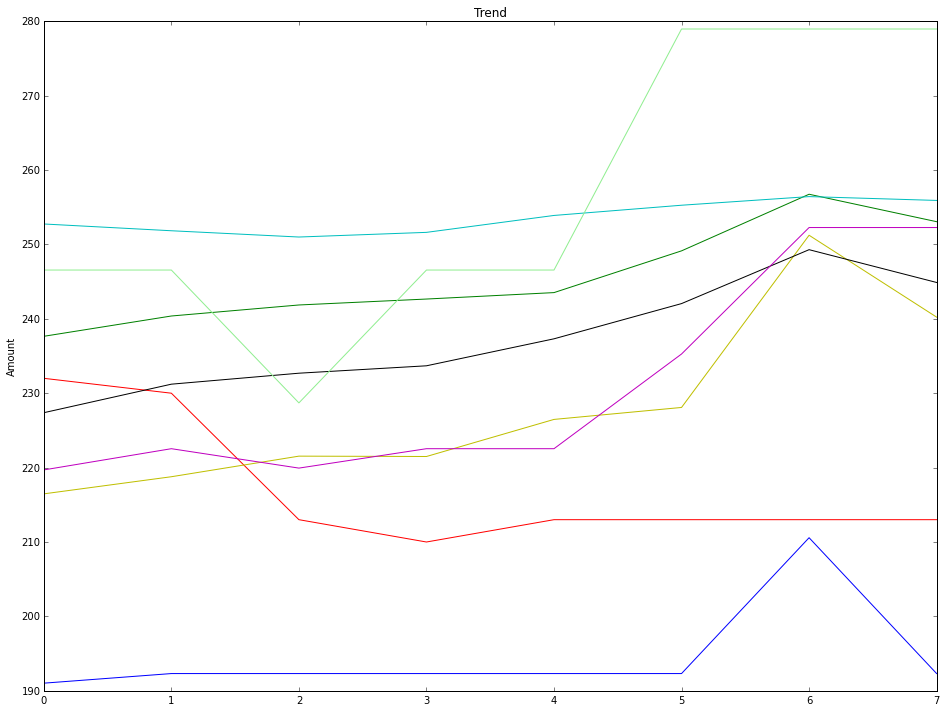

In [164]:
import matplotlib.pyplot as plt
%matplotlib inline

#not green market
m1 = (pred['ActualUrea'])
m2 = (pred['RDF96_05'])
m3 = (pred['MLR96_05'])
m4 = (pred['RDF_China'])
m5 = (pred['MLR_China'])
m6 = (pred['RDF_Sec1'])
m7 = (pred['MLR_Sec1'])
m8 = (pred['RDF_Sec1Dollar'])
m9 = (pred['MLR_Green'])
m10 = (pred['GreenActual'])
plt.figure(figsize=(16,12))
plt.plot(m1,'r')
plt.plot(m2,'b')
plt.plot(m3,'g')
plt.plot(m4,'y')
plt.plot(m5,'k')
plt.plot(m6,'m')
plt.plot(m7,'c')
plt.plot(m8,'lightgreen')

plt.ylabel('Amount')
plt.title('Trend')
plt.show()

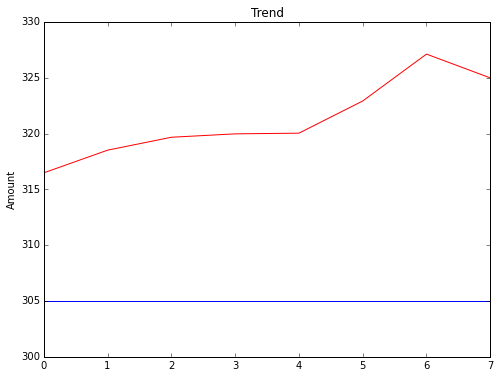

In [175]:
plt.figure(figsize=(8,6))
plt.plot(m9,'r')
plt.plot(m10,'b')  #on baseline
plt.ylim(300,330)
plt.ylabel('Amount')
plt.title('Trend')
plt.show()

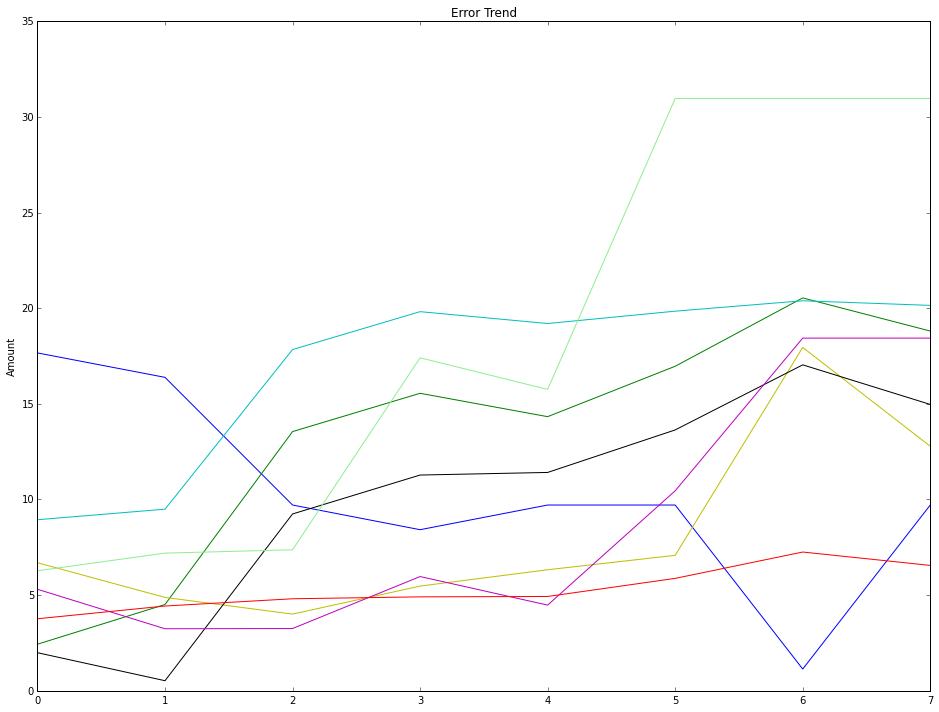

In [177]:
em2 = (pred['Error_RDF96_05'])
em3 = (pred['Error_MLR96_05'])
em4 = (pred['Error_RDF_China'])
em5 = (pred['Error_MLR_China'])
em6 = (pred['Error_RDF_Sec1'])
em7 = (pred['Error_MLR_Sec1'])
em8 = (pred['Error_RDF_Sec1Dollar'])
em9 = (pred['Error_Green'])
plt.figure(figsize=(16,12))
plt.plot(em2,'b')
plt.plot(em3,'g')
plt.plot(em4,'y')
plt.plot(em5,'k')
plt.plot(em6,'m')
plt.plot(em7,'c')
plt.plot(em8,'lightgreen')
plt.plot(em9,'r')

plt.ylabel('Amount')
plt.title('Error Trend')
plt.show()

In [186]:
#each models average error
av1 = pred['Error_RDF96_05'].mean()
av2 = pred['Error_MLR96_05'].mean()
av3 = pred['Error_RDF_China'].mean()
av4 = pred['Error_MLR_China'].mean()
av5 = pred['Error_RDF_Sec1'].mean()
av6 = pred['Error_MLR_Sec1'].mean()
av7 = pred['Error_RDF_Sec1Dollar'].mean()
av8 = pred['Error_Green'].mean()

print 'Error_RDF96_05: %.3f' % av1
print 'Error_MLR96_05: %.3f' % av2
print 'Error_RDF_China: %.3f' % av3
print 'Error_MLR_China: %.3f' % av4
print 'Error_RDF_Sec1: %.3f' % av5
print 'Error_MLR_Sec1: %.3f' % av6
print 'Error_RDF_Sec1Dollar: %.3f' % av7
print 'Error_Green: %.3f' % av8

Error_RDF96_05: 10.306
Error_MLR96_05: 13.335
Error_RDF_China: 8.149
Error_MLR_China: 10.012
Error_RDF_Sec1: 8.697
Error_MLR_Sec1: 16.958
Error_RDF_Sec1Dollar: 18.361
Error_Green: 5.317
